__Mini Project - Detecting Skin Cancer__

In this mini project, we will design an algorithm that can visually diagnose melanoma, 
the deadliest form of skin cancer. 

In particular, our algorithm will distinguish this 
malignant skin tumor from two types of benign lesions (nevi and seborrheic keratoses).

In [2]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np

Using TensorFlow backend.


In [4]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    paths = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']))
    return paths, targets

In [7]:
train_files, train_targets = load_dataset('data/train')
valid_files, valid_targets = load_dataset('data/valid')
test_files, test_targets = load_dataset('data/test')

In [9]:
from os import listdir

diseases = sorted(listdir('data/train'))

print('There are {} classes: {}.'.format(len(diseases), ', '.join(diseases)))
print('There are {} training images.'.format(len(train_files)))
print('There are {} validation images.'.format(len(valid_files)))
print('There are {} testing images.'.format(len(test_files)))

There are 3 classes: melanoma, nevus, seborrheic_keratosis.
There are 2000 training images.
There are 150 validation images.
There are 600 testing images.


In [10]:
from keras.preprocessing import image
from tqdm import tqdm_notebook

def get_tensor(path):
    img = image.load_img(path, target_size=(224, 224))
    return np.expand_dims(image.img_to_array(img), axis=0)

def get_tensors(paths):
    return np.vstack([get_tensor(path) for path in tqdm_notebook(paths)])

In [11]:
from keras.applications.resnet50 import preprocess_input

train_tensors = preprocess_input(get_tensors(train_files))
valid_tensors = preprocess_input(get_tensors(valid_files))
test_tensors = preprocess_input(get_tensors(test_files))

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [12]:
from keras.applications.resnet50 import ResNet50
resnet50 = ResNet50(include_top=False, input_shape=(224, 224, 3))

In [13]:
train_bottleneck = resnet50.predict(train_tensors)
valid_bottleneck = resnet50.predict(valid_tensors)
test_bottleneck = resnet50.predict(test_tensors)

In [34]:
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Sequential

print ('train_bottleneck shape: ', train_bottleneck.shape)
print ('test_bottleneck shape: ', test_bottleneck.shape)
print ('valid_bottleneck shape: ', valid_bottleneck.shape)
model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=train_bottleneck.shape[1:]))
model.add(Dropout(0.5))
model.add(Dense(1500, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1500, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

train_bottleneck shape:  (2000, 1, 1, 2048)
test_bottleneck shape:  (600, 1, 1, 2048)
valid_bottleneck shape:  (150, 1, 1, 2048)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_7 ( (None, 2048)              0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 1500)              3073500   
_________________________________________________________________
dropout_14 (Dropout)         (None, 1500)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 1500)              2251500   
_________________________________________________________________
dense_21 (Dense)             (None, 3)                 4503      
Total params:

In [23]:
from keras import optimizers

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
              optimizer=optimizers.SGD(lr=0.0001, momentum=0.9, decay=1e-6))

# model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
#               optimizer=optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-5, decay=1e-5))

In [24]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='resnet.from.bottleneck.hdf5', save_best_only=True)
history = model.fit(train_bottleneck, train_targets, epochs=100,
          validation_data=(valid_bottleneck, valid_targets),
          callbacks=[checkpointer], verbose=1, shuffle=True)

Train on 2000 samples, validate on 150 samples
Epoch 1/100
2000/2000 [==============================] - 2s 1ms/step - loss: 1.0857 - acc: 0.5900 - val_loss: 0.9986 - val_acc: 0.5200
Epoch 2/100
2000/2000 [==============================] - 2s 838us/step - loss: 0.9340 - acc: 0.6340 - val_loss: 0.9375 - val_acc: 0.5400
Epoch 3/100
2000/2000 [==============================] - 2s 894us/step - loss: 0.9209 - acc: 0.6385 - val_loss: 0.8703 - val_acc: 0.6133
Epoch 4/100
2000/2000 [==============================] - 2s 887us/step - loss: 0.8740 - acc: 0.6405 - val_loss: 0.8395 - val_acc: 0.6133
Epoch 5/100
2000/2000 [==============================] - 2s 954us/step - loss: 0.8360 - acc: 0.6685 - val_loss: 0.8174 - val_acc: 0.6533
Epoch 6/100
2000/2000 [==============================] - 2s 801us/step - loss: 0.8510 - acc: 0.6390 - val_loss: 0.8203 - val_acc: 0.6400
Epoch 7/100
2000/2000 [==============================] - 2s 905us/step - loss: 0.8324 - acc: 0.6670 - val_loss: 0.7979 - val_acc: 0.6

In [25]:
model.load_weights('resnet.from.bottleneck.hdf5')

In [26]:

print('\nTesting loss: {:.4f}\nTesting accuracy: {:.4f}'.format(*model.evaluate(test_bottleneck, test_targets)))

600/600 [==============================] - 0s 189us/step

Testing loss: 0.7457
Testing accuracy: 0.7050


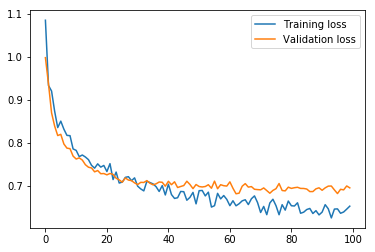

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

AUC for melanoma: 0.7339
AUC for nevus: 0.8348
AUC for seborrheic_keratosis: 0.8953


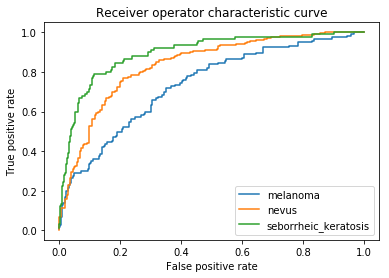

In [28]:
from sklearn.metrics import roc_curve, auc

for i in range(len(diseases)):
    fpr, tpr, _ = roc_curve(test_targets[:,i], model.predict(test_bottleneck)[:,i])
    print('AUC for {}: {:.4f}'.format(diseases[i], auc(fpr, tpr)))
    plt.plot(fpr, tpr, label=diseases[i])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('Receiver operator characteristic curve')
plt.show()

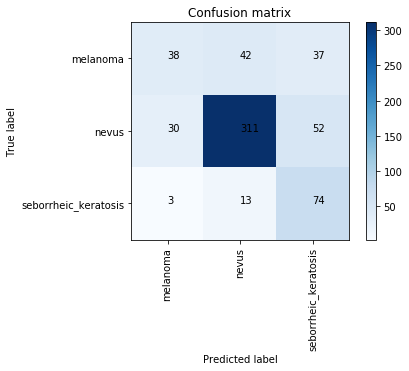

In [29]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(np.argmax(test_targets, axis=1),
                      np.argmax(model.predict(test_bottleneck), axis=1))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
indexes = np.arange(len(diseases))
for i in indexes:
    for j in indexes:
        plt.text(j, i, cm[i, j])
plt.xticks(indexes, diseases, rotation=90)
plt.xlabel('Predicted label')
plt.yticks(indexes, diseases)
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

In [30]:
import csv

with open('predictions.csv', 'w') as f:
    csvwriter = csv.writer(f)
    csvwriter.writerow(['Id', 'task_1', 'task_2'])
    for path in tqdm_notebook(sorted(test_files)):
        tensor = preprocess_input(get_tensor(path))
        pred = model.predict(resnet50.predict(tensor))[0]
        csvwriter.writerow([path, pred[0], pred[2]])

A Jupyter Widget